# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
from IPython.display import HTML, display


import sys, datetime
import os
from numba import njit, prange
from helper import *
import itertools as it

import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

%matplotlib inline
import matplotlib as mpl

from matplotlib.ticker import NullFormatter, MaxNLocator, MultipleLocator
mpl.rcParams.update({"font.size": 12})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.animation as anime

from sklearn.datasets import fetch_openml

## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

## Parameters

In [3]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units

dname='DATA/'
################################


## Select data, and digitalize them two levels

In [4]:
# Selecting digits to use
list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[-Ndigit:] 
print('Chosen digits: ',list_digits)

# keep only X and Y in list_digitssssssssss
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]


#data,label = MNIST_bit(X_keep, x_min = x_min),Y
#data,label = data.astype("int"),label.astype("int")

# number of data points
#Nd = len(data)
# number of visible units - I.e. total pixels of the image
#D  = len(data[1])


Chosen digits:  ('7', '8', '9')


## Plotting data

In [5]:
#print(f"Extract of MNIST-{Ndigit} data points, binarized")
#for i in range(4): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
#@jit(parallel=True)
def CD_step(v_in,wei,bias, a_func=np.exp, details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in.astype(np.float64), wei) + bias, a_min=-300, a_max=300)
    # "activation" note, it is a sigmoid
    a = a_func(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        
        # Probability of turning on a hidden unit
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]:
            i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return (v_out,p,a)
    else: return v_out

## Plot weights

## Weights initialization 
The initialization proposed by Hinton for the bias $a_i$ of a visible unit $v_i$ is given by the formula $ a_i = \log(\frac{p_i}{1-p_i})$ (Hinton 2012), where $p_i$ is the fraction of training samples in which the unit $i$ is on. 
When updating the visible states, $p_i$ corresponds to the probability of having a visible state equal to 1, which is used to stochastically pick the value of each visible unit. The probability of activation for a visible neuron is $P(x_i=1|h)= \sigma(a_i + \sum_j h_j w_{ij})$ (Hinton 2012) where $\sigma(x) = \frac{1}{1+e^{-x}}$ is a sigmoid function. If we set $w_{ij}\sim 0$, we have $P(x_i=1) \sim \sigma(a_i)$, hence $\sigma(a_i) = p_i$.

The biases are set so that the neurons have on average an activation that matches the distribution of the training data (Mehta 2019). This helps stabilize learning and prevents the model from learning too slowly.
In a qualitative way, if a pixel is often active in the dataset ($p\sim 1$), the bias will be higly positive, encouraging the neuron to be active. On the contrary, if a pixel is rarely active ($p_i \sim 0$), the bias will be highly negative, discouraging activation. If $p_i = 0.5$, the bias will be zero, meaning the neuron has a neutral activation probability.

In the function $Hinton$ _ $bias$ _ $init(x)$ , an average on the data is made for each column obtaining the vector xmean.
The vector is then 'refined' setting values that are too close to the lower ($-1$ or $0$) and upper (1) state to a higher (first case) or lower value (second case). This is to avoid divergences when computing the logarithms. 
Finally, the function returns the vector of biases based on the formula above.

In [7]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    '''
    x ::shape of 'x'(data): (21770,784)
    xmean :: does the mean on 'data' for each column -> shape of xmean :(,784)
     xmin =0, xmax=1 if SPINS=FALSE, otherwise {-1,+1}
    since np.precision is set at 4 -> S = 1e-4
    level_gap :: is the difference in values between the max (1) and the min (x_min)
    np.clip :: avoid minimum maximum overflow, inf and -inf values.
    '''
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S 
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    


## Log-Likelihood


We trained the RBM on digits 7,8,9, trying with number of hidden units L $\in [3,4,5,6,7]$, and for each value we tried different CD steps, $Nt \in [2,4,6,8,10,12]$.

Log-likelihood generally increases during training, what you can see in the resume above are graphs of the LL taken every 5 epochs to spare us computational time and get as soon as possible an overview.

What we see is that number of CD steps matters a little bit in LL increase, 2-3 points, and it depends more on the number of hidden units. Best final values are for L=7. It is interesting to see that sometimes LL stalls after a initial steep increase. This could mean that the model fits the data soon, and then keeps wandering in the hyperspace. 

As Hinton suggests, best results with multidimensional data are reached with more hidden units than the necessary bits to describe the label, but would be optimal to have the same number of hidden units as the length of the data vector. With our computational capabilities this is very difficult to realize, it would mean 20-30 hidden units.



In [8]:
def generate_configurations(L):
    """Generate all binary configurations of length L."""
    if POTTS: return np.eye(L)
    return np.array(list(it.product((0,1), repeat=L)), dtype=np.int64)

def compute_log_likelihood(partition,data, a, b, w, configurations):
    log_likelihoods = np.zeros(len(data))  # Preallocate array
    #all_conf = generate_configurations(L)  # Compute binary configs once

    Hz_cache = np.array([H(a,w,z.astype(np.float64)) for z in configurations])  # Precompute H(z)

    for i, x in enumerate(data): 
        Z_x = 0.0
        for Hz, z in zip(Hz_cache, configurations):
            E_xz = -np.dot(Hz, x) - np.dot(b, z)
            Z_x += np.exp(-E_xz)

        log_likelihoods[i] = np.clip(np.log(Z_x) - partition, a_min=-700, a_max=+7000)

    return np.mean(log_likelihoods)

@njit(parallel=True)
def H(a,w,z):  
    return a + np.dot(w, z)  

@njit(parallel=True)
def G(b,z):  
    return np.prod(np.exp(b * z))

@njit(parallel=True)
def partition_function(a,w,b,configurations):
    sum_values = np.zeros(1, dtype=np.float64)#0.0  # Use scalar accumulation

    for i in prange(configurations.shape[0]):
        z = configurations[i]
        Hz = H(a,w,z.astype(np.float64))
        produttoria_H = np.prod(1 + np.exp(Hz))
        sum_values += G(b,z.astype(np.float64)) * produttoria_H

    return np.log(sum_values[0])

## Setting up RBM for cross validation

We use the same code used for training to perform a cross validation. This time we only select the 6 best models from the previous discussion.
In the code below are shown the hyperparameters of the last best model (number 5).

In [16]:
import time
## Hyper parameters::
L = 55
print(f'L, hidden units: {L}')

SPINS = False
print(f'SPINS: {SPINS}')

POTTS = True
print(f'POTTS: {POTTS}')

active = np.exp
print(f'activation func: {active}')

gamma = 0.1
print(f'gamma: {gamma}')

GRAD = 'RMSprop'
print(f'GRADa: {GRAD}')

# number of CD steps
Nt = 2
print(f'Nt: {Nt}')

Nepoch = 450
print(f'Epochs: {Nepoch}')

# number of minis
Nmini = 50
print(f'Nmini: {Nmini}')

N_ini = 10
print(f'Nini: {N_ini}')

N_fin = 300
print(f'Nfin: {N_fin}')

## momentum
m = .2
print(f'm: {m}')

M = .5
print(f'Final m: {M}')
      
## setup for gradient choice & gamma, momentum
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1,0.25
elif GRAD=="RMSprop":
    beta,epsilon=0.9,1e-8
    #l_rate_ini,l_rate_fin=0.05,0.05
    l_rate_ini,l_rate_fin=0.1,0.01
    print("epsilon=",epsilon)
else:
    l_rate_ini,l_rate_fin=0.05,0.05
    beta1, beta2, epsilon = .9, .999, 1e-8

##setup for spin/potts/other thing
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    Nz=L
else:
    str_simul="RBM"
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

# data binarization
data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
# number of data points
Nd = len(data)
# number of visible units - I.e. total pixels of the image
D  = len(data[1])

# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

L, hidden units: 55
SPINS: False
POTTS: True
activation func: <ufunc 'exp'>
gamma: 0.1
GRADa: RMSprop
Nt: 2
Epochs: 450
Nmini: 50
Nini: 10
Nfin: 300
m: 0.2
Final m: 0.5
epsilon= 1e-08
Dataset with 21076 points, each with 784 bits

D=784	sample size
L=55	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.1 --> 0.01
gamma=0.1	regularization


## CV Run

We perform the cross validation by running the learning algorithm using different random seeds. 

Nepoch=450
Nmini=50


<Figure size 640x480 with 0 Axes>

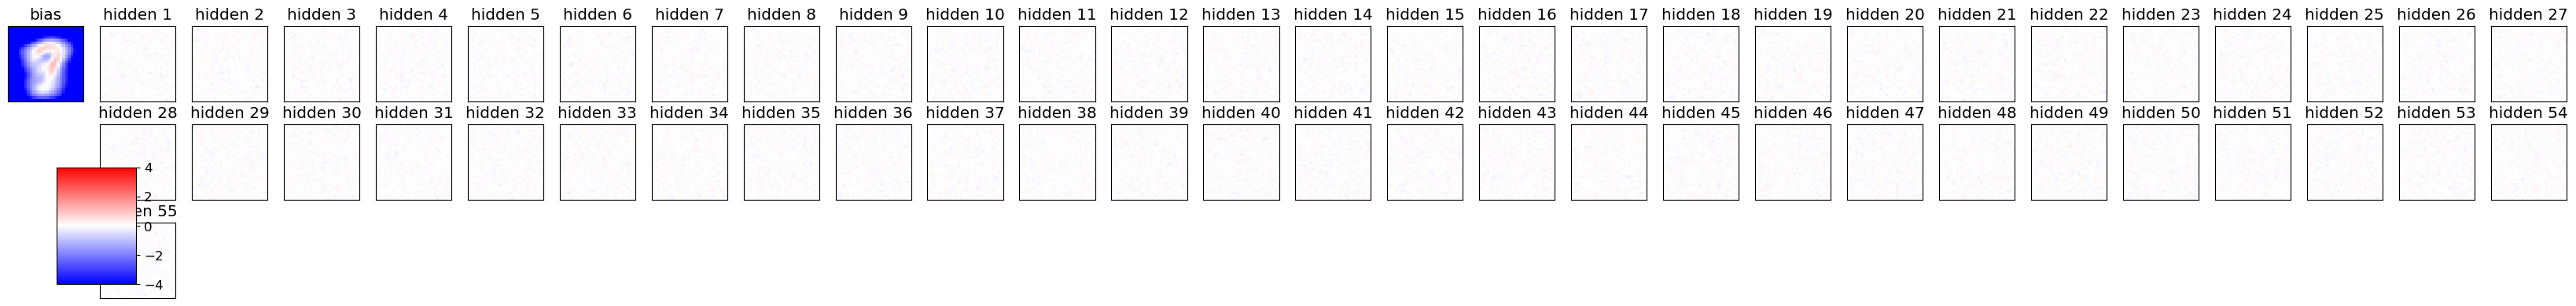

Starting the training, POTTS=True
_20250401_0047
epoch 1 / 450  Nt: 2  N: 10  L: 55  rate: 0.1  m: 0.2 SPINS= False POTTS= True
epoch 2 / 450  Nt: 2  N: 10  L: 55  rate: 0.09979955456570157  m: 0.2 SPINS= False POTTS= True
epoch 3 / 450  Nt: 2  N: 10  L: 55  rate: 0.09959910913140313  m: 0.2 SPINS= False POTTS= True
epoch 4 / 450  Nt: 2  N: 10  L: 55  rate: 0.09939866369710468  m: 0.2 SPINS= False POTTS= True
epoch 5 / 450  Nt: 2  N: 10  L: 55  rate: 0.09919821826280624  m: 0.2 SPINS= False POTTS= True


<Figure size 640x480 with 0 Axes>

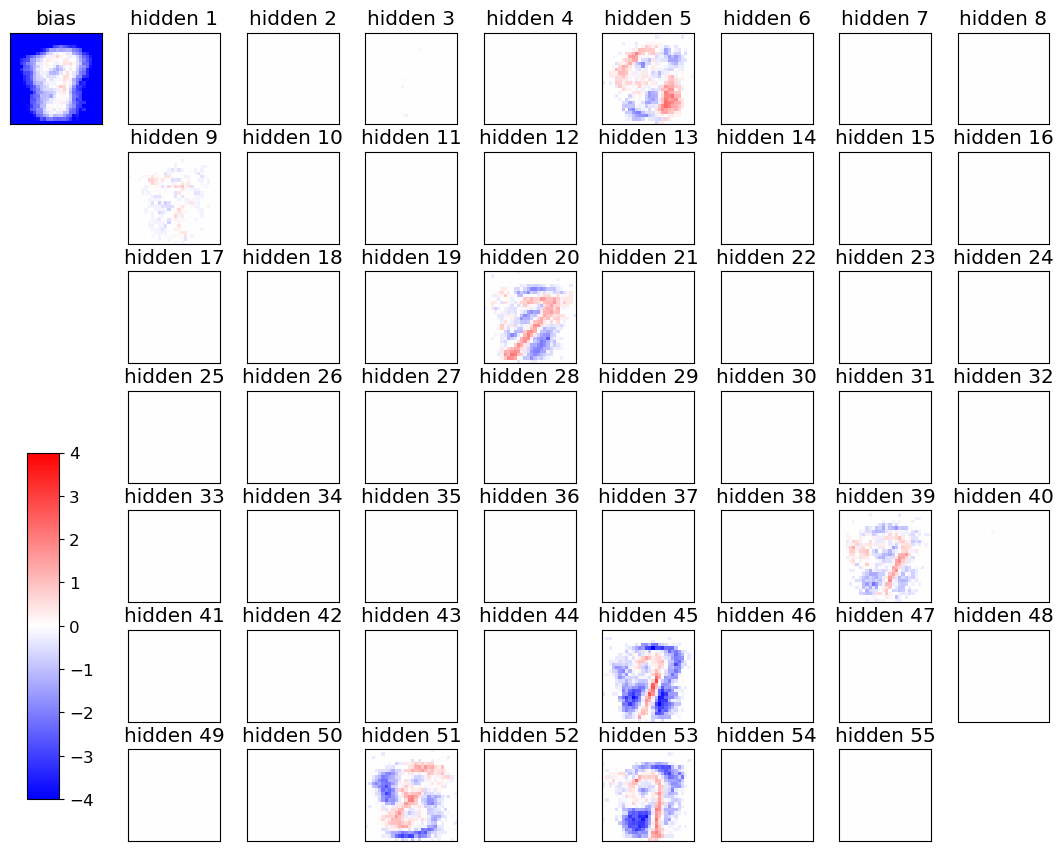

-171.99248542247915
epoch 6 / 450  Nt: 2  N: 10  L: 55  rate: 0.0989977728285078  m: 0.2 SPINS= False POTTS= True
epoch 7 / 450  Nt: 2  N: 10  L: 55  rate: 0.09879732739420936  m: 0.2 SPINS= False POTTS= True
epoch 8 / 450  Nt: 2  N: 10  L: 55  rate: 0.09859688195991091  m: 0.2 SPINS= False POTTS= True
epoch 9 / 450  Nt: 2  N: 10  L: 55  rate: 0.09839643652561247  m: 0.2 SPINS= False POTTS= True
epoch 10 / 450  Nt: 2  N: 10  L: 55  rate: 0.09819599109131404  m: 0.2 SPINS= False POTTS= True


<Figure size 640x480 with 0 Axes>

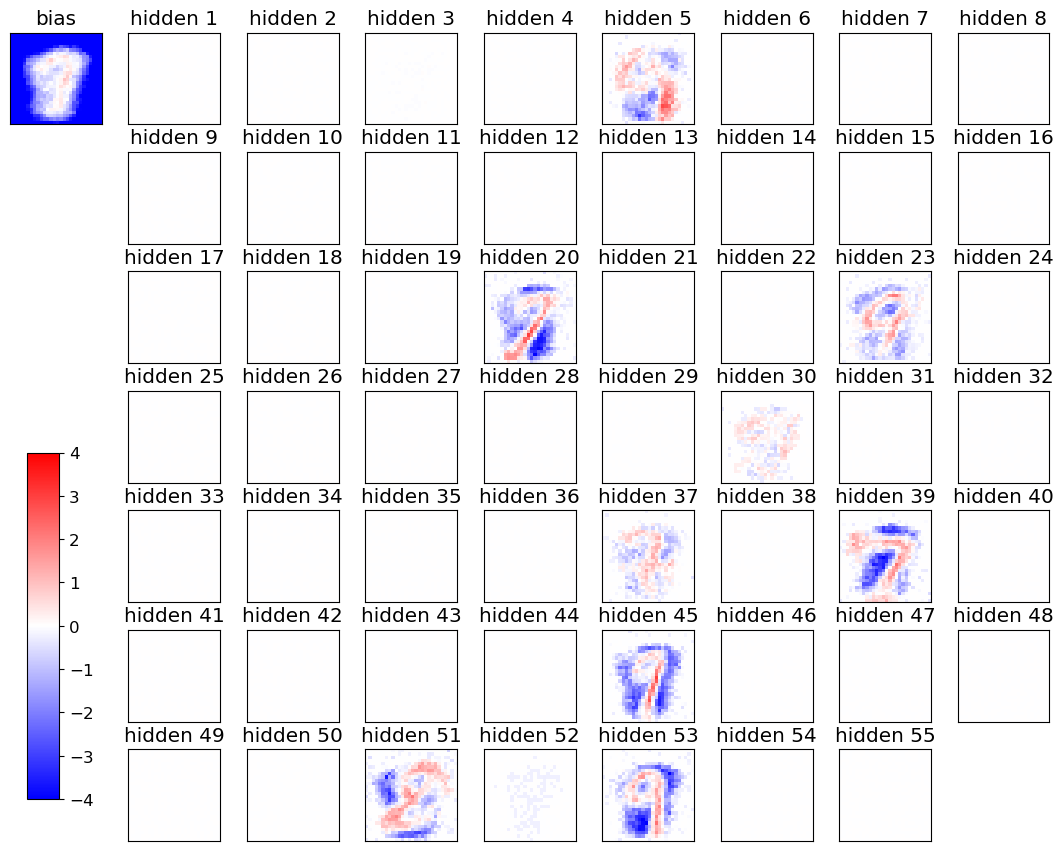

-174.4994593345851
epoch 11 / 450  Nt: 2  N: 10  L: 55  rate: 0.0979955456570156  m: 0.2 SPINS= False POTTS= True
epoch 12 / 450  Nt: 2  N: 10  L: 55  rate: 0.09779510022271716  m: 0.2 SPINS= False POTTS= True
epoch 13 / 450  Nt: 2  N: 10  L: 55  rate: 0.09759465478841871  m: 0.2 SPINS= False POTTS= True
epoch 14 / 450  Nt: 2  N: 10  L: 55  rate: 0.09739420935412027  m: 0.2 SPINS= False POTTS= True
epoch 15 / 450  Nt: 2  N: 10  L: 55  rate: 0.09719376391982183  m: 0.2 SPINS= False POTTS= True


<Figure size 640x480 with 0 Axes>

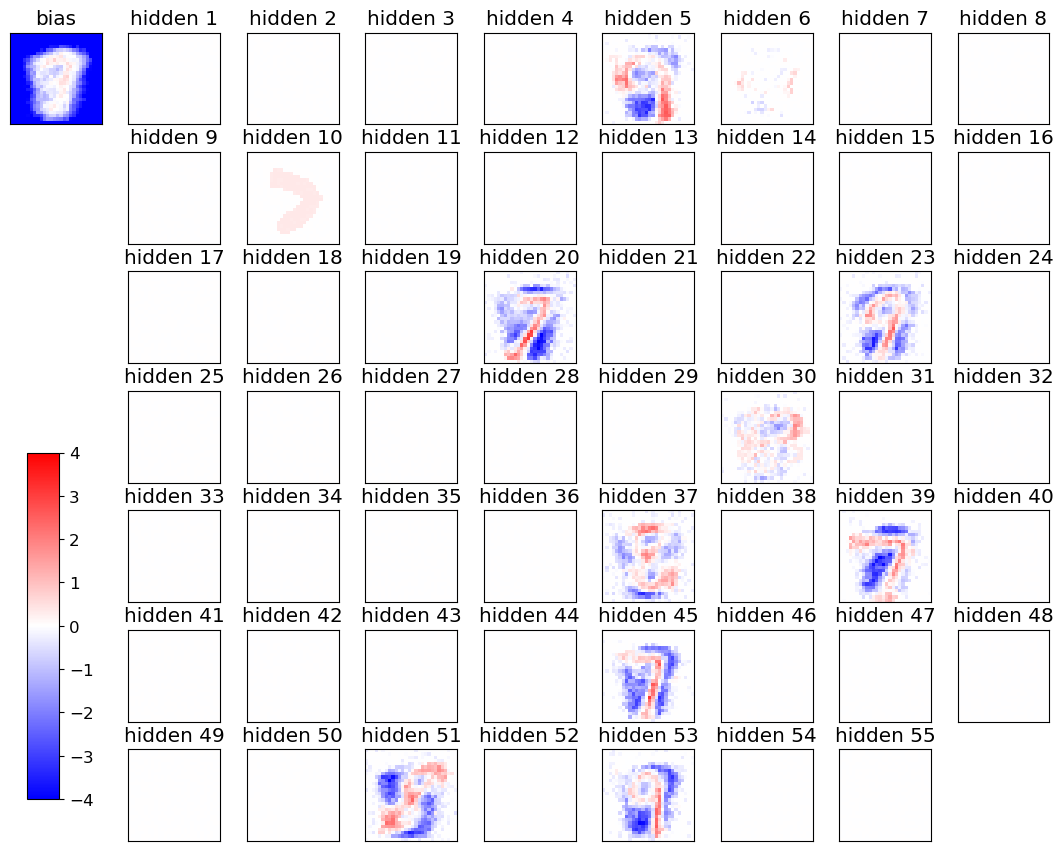

-172.2282629506418
epoch 16 / 450  Nt: 2  N: 10  L: 55  rate: 0.0969933184855234  m: 0.2 SPINS= False POTTS= True
epoch 17 / 450  Nt: 2  N: 10  L: 55  rate: 0.09679287305122496  m: 0.2 SPINS= False POTTS= True
epoch 18 / 450  Nt: 2  N: 10  L: 55  rate: 0.0965924276169265  m: 0.2 SPINS= False POTTS= True
epoch 19 / 450  Nt: 2  N: 10  L: 55  rate: 0.09639198218262807  m: 0.2 SPINS= False POTTS= True
epoch 20 / 450  Nt: 2  N: 10  L: 55  rate: 0.09619153674832963  m: 0.2 SPINS= False POTTS= True


<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [17]:
for seed in [12]:#, 12, 123, 1234, 12345, 123457]:
    np.random.seed(seed)
    
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(D,L)
    # using Hinton initialization of visible biases
    a = Hinton_bias_init(data)
    # hidden biases initialized to zero
    b = np.zeros(L)
    print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    # recording history of weights ("E" means epoch)
    wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L)) 
    wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
    gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
    gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
    gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
    miniE = np.zeros(Nepoch+1)
    pzE=np.zeros((Nepoch+1,Nz))
    
    if m > 0: 
        bw = np.zeros_like(w)
        ba = np.zeros_like(a)
        bb = np.zeros_like(b)
    
    if GRAD=="RMSprop": 
        gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    
    elif GRAD=='Adam':
        mw, ma, mb = np.zeros_like(w), np.zeros_like(a), np.zeros_like(b)
        vw, va, vb = np.zeros_like(w), np.zeros_like(a), np.zeros_like(b)

    
    indices=np.arange(Nd).astype("int")
    plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
    
    # for the plot with panels
    Ncols=min(8,max(2,L//2))
    
    if POTTS: print("Starting the training, POTTS=True")
    else: print("Starting the training")
    print((ddate := datetime.datetime.now().strftime("_%Y%m%d_%H%M")))
    
    configurations = generate_configurations(L)
    log_likelihoods = []
    lista_epoch_grafico = []
    # Note: here an epoch does not analyze the whole dataset

    ### special growth pt 1
    mt = m
    llhE = []
    for epoch in range(1,1+Nepoch):
        # q maps epochs to interval [0,1]
        q = (epoch-1.)/(Nepoch-1.) 
        # N, size of the mini batch
        # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
        N = int(N_ini + (N_fin-N_ini)*(q**2))
        #  l_rate interpolates between initial and final value
        l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

        ### special growth pt fin
        if q >= .6 and mt != M: mt = M

        ### 'quadratic growth of m'
        # mt = m + (M-m) * (q**2)
    
        for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
    
            # Minibatch of size N: points randomply picked (without repetition) from data
            selected = np.random.choice(indices,N,replace=False)
           # if epoch==1 and mini<=3: print(selected)
    
            for k in range(N):
                ###################################
                x0 = data[selected[k]]
                # positive CD phase: generating z from x[k]
                z = CD_step(x0,w,b,a_func=active,POTTS=POTTS)
                x_data  += x0
                z_data  += z
                xz_data += np.outer(x0,z)
                # fantasy
                zf=np.copy(z)
                # Contrastive divergence with Nt steps
                for t in range(Nt):
                    # negative CD pzase: generating fantasy xf from fantasy zf
                    xf = CD_step(zf,w.T, a, a_func=active)
                    # positive CD phase: generating fantasy zf from fantasy xf 
                    zf = CD_step(xf,w,b,a_func=active,POTTS=POTTS)
                x_model += xf
                z_model += zf
                xz_model+= np.outer(xf,zf)
                # recording probability of encoding in z-space, if POTTS
                if POTTS: pz[zf]+=1
                ###################################
    
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)
    
            # gradient ascent step
            if GRAD=="RMSprop":
                # RMSprop gradient ascent
                gw2 = beta*gw2+(1-beta)*np.square(gw)
                ga2 = beta*ga2+(1-beta)*np.square(ga)
                gb2 = beta*gb2+(1-beta)*np.square(gb)
                if m > 0:
                    bw = mt * bw + gw / sqrt(epsilon+gw2)
                    ba = mt * ba + ga / sqrt(epsilon+ga2)
                    bb = mt * bb + gb / sqrt(epsilon+gb2)
                    
                    w += l_rate * bw
                    a += l_rate * ba
                    b += l_rate * bb
                else:
                    w += l_rate*gw/sqrt(epsilon+gw2)
                    a += l_rate*ga/sqrt(epsilon+ga2)
                    b += l_rate*gb/sqrt(epsilon+gb2)
                    
                
            elif GRAD=='SGD': 
                # defaulting to the vanilla stochastic gradient ascent (SGD)
                if m > 0:
                    bw = mt * bw + gw
                    ba = mt * ba + ga
                    bb = mt * bb + gb
                    gw, ga, gb = bw, ba, bb
                w += l_rate*gw
                a += l_rate*ga
                b += l_rate*gb

            else:
                # Adam
                mw = beta1 * mw + (1 - beta1) * gw
                ma = beta1 * ma + (1 - beta1) * ga
                mb = beta1 * mb + (1 - beta1) * gb
                
                vw = beta2 * vw + (1 - beta2) * np.square(gw)
                va = beta2 * va + (1 - beta2) * np.square(ga)
                vb = beta2 * vb + (1 - beta2) * np.square(gb)
                
                mwhat = mw / (1 - beta1 ** (mini + 1))
                mahat = ma / (1 - beta1 ** (mini + 1))
                mbhat = mb / (1 - beta1 ** (mini + 1))
                
                vwhat = vw / (1 - beta2 ** (mini + 1))
                vahat = va / (1 - beta2 ** (mini + 1))
                vbhat = vb / (1 - beta2 ** (mini + 1))
                

                w += l_rate * mwhat / sqrt(epsilon + vwhat)
                a += l_rate * mahat / sqrt(epsilon + vahat)
                b += l_rate * mbhat / sqrt(epsilon + vbhat)

                
            # regularization (LASSO)
            if gamma>0.:
                w -= (gamma*l_rate)*sign(w)
                a -= (gamma*l_rate)*sign(a)
                b -= (gamma*l_rate)*sign(b)
    
        wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
        aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
        bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
        miniE[epoch]=N
        if POTTS: pzE[epoch] = pz/np.sum(pz)
        print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L, " rate:",l_rate," m:",mt,"SPINS=",SPINS,"POTTS=",POTTS)
        if epoch%5==0 or epoch==Nepoch: plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
        if epoch % 5 == 0 or epoch==Nepoch:
            partition = partition_function(a,w,b,configurations)
            log_likelihood = compute_log_likelihood(partition,data, a=a, b=b, w=w,configurations=configurations)
            llhE.append(epoch)
            print(log_likelihood)
            with open((llh_file := f'newruns/llh/{ddate}_{str_simul}_SP{SPINS}_L{L}_act{active}_gam{gamma}_grad{GRAD}_steps{Nt}_epochs{Nepoch}_minis{Nmini}_Nini{N_ini}_Nfin{N_fin}_m{m}_M{M}_lri{l_rate_ini}_lrf{l_rate_fin}'), 'a') as add:
                print(log_likelihood, file=add)
    print("END of learning phase", datetime.datetime.now().strftime("_%Y%m%d_%H%M"))
    for sa, ve in zip(['w', 'a', 'b'], [wE, aE, bE]): np.save(f'newruns/weights/{ddate}_{str_simul}_SP{SPINS}_L{L}_act{active}_gam{gamma}_grad{GRAD}_steps{Nt}_epochs{Nepoch}_minis{Nmini}_Nini{N_ini}_Nfin{N_fin}_m{m}_M{M}_lri{l_rate_ini}_lrf{l_rate_fin}___{sa}.npy', ve)

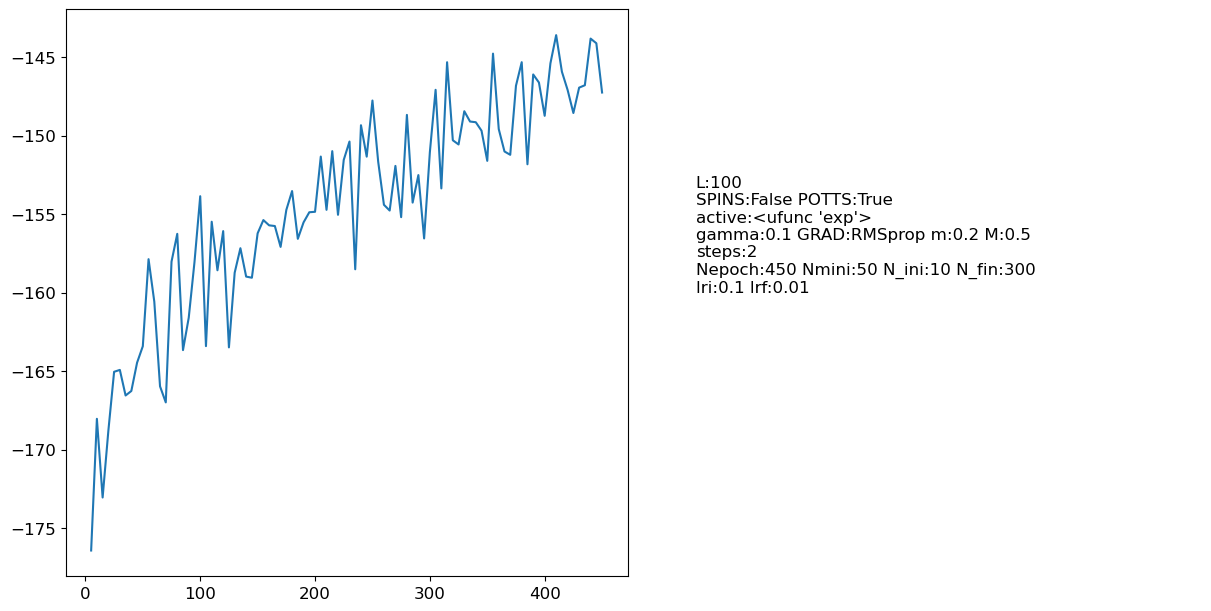

In [11]:
stringa = f'L:{L}\nSPINS:{SPINS} POTTS:{POTTS}\nactive:{active}\ngamma:{gamma} GRAD:{GRAD} m:{m} M:{M}\nsteps:{Nt}\nNepoch:{Nepoch} Nmini:{Nmini} N_ini:{N_ini} N_fin:{N_fin}\nlri:{l_rate_ini} lrf:{l_rate_fin}'

fig, ax = plt.subplots(1,2, figsize=(12,6), layout='constrained')

plot_stuff = np.loadtxt(llh_file)
ax[0].plot(llhE, plot_stuff)
#ax[0].set_xticks(np.arange(0, len(llh_file) + 1, 5))
ax[1].set_axis_off()
ax[1].text(.1,.5, stringa)
fig.savefig('newruns/img/' + f'{ddate}_L-{L}_SPINS-{SPINS}_POTTS-{POTTS}_active-{active}_gamma-{gamma}_GRAD-{GRAD}_m-{m}_M-{M}_steps-{Nt}_Nepoch-{Nepoch}_Nmini-{Nmini}_N_ini-{N_ini}_N_fin-{N_fin}' + '.png')
plt.show()

## Test generative power of the best model

Here we use model 5 to generate and show new data.

<Figure size 640x480 with 0 Axes>

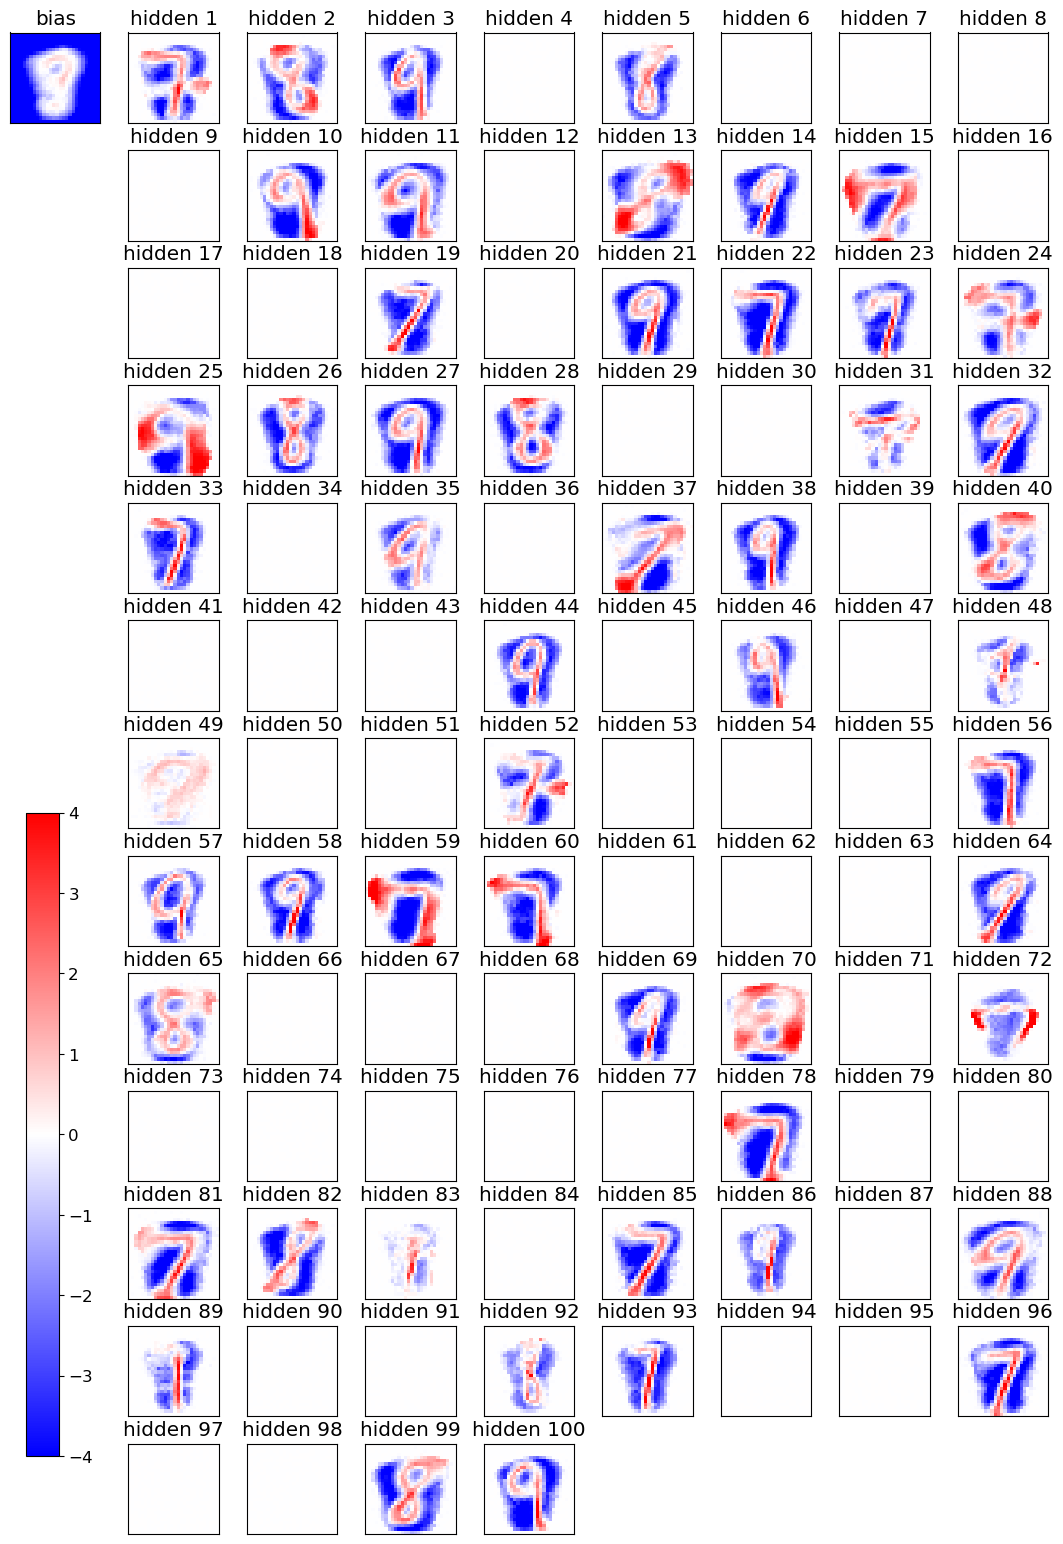

L: 100     amplification of weights: 5 lab 9


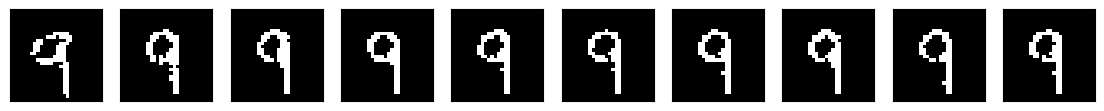

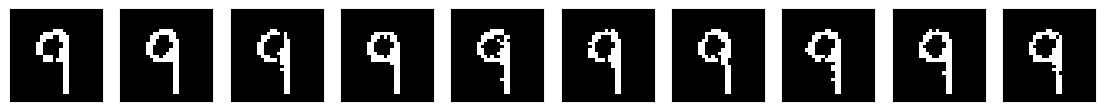

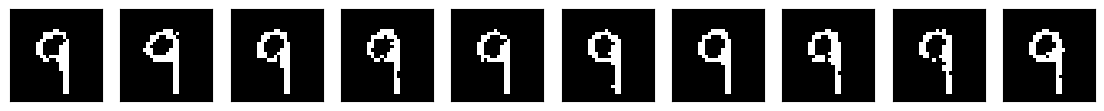

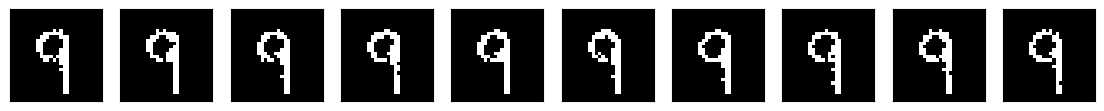

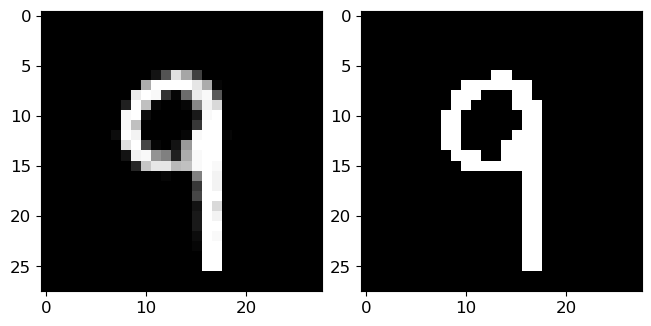

In [15]:
ee=-1 ##
NN=40
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[(danum := np.random.randint(Nd))])
labf=label[danum]
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=5

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf
    zf = CD_step(xf,1*wE[ee],1*bE[ee], a_func=active, POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T, AF*aE[ee], a_func=active)
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

print("L:",L,"    amplification of weights:",AF, 'lab', labf)
bindarcy = [np.where(np.mean(traj_x[1:i], axis=0).reshape(28,28) > .5, 1, 0) for i in range(2, traj_x.shape[0])]
for i in range(0, NN, 10):
    show_MNIST(traj_x[i:],Nex=10)


travj_x = np.mean(traj_x[1:], axis=0)
bintravj_x = np.where(travj_x > .5, 1, 0)
fig, ax = plt.subplots(1, 2, layout='constrained')
ax[0].imshow(travj_x.reshape(28,28), cmap='gray')
ax[1].imshow(bintravj_x.reshape(28,28), cmap='gray')
plt.show()


In [15]:
#skibidi = traj_x[1:].reshape(traj_x[1:].shape[0], 28, 28)
#darcy = [np.mean(traj_x[1:i], axis=0).reshape(28,28) for i in range(2, traj_x.shape[0])]
bindarcy = [np.where(np.mean(traj_x[1:i], axis=0).reshape(28,28) > .5, 1, 0) for i in range(2, traj_x.shape[0])]
fig, ax = plt.subplots(layout='constrained')
ims = [[ax.imshow(bindarcy[i], cmap='gray', animated=True)] for i in range(len(bindarcy))]
ani = anime.ArtistAnimation(fig, ims, interval=150, blit=True)

display(HTML(ani.to_html5_video()))
#ani.save('7.gif')

## Model scores
We plot the scores related to the 6 best models that we chose. We see that we get for all models approximately the same error bars and the same result.
We also note that five out of six models have as hyperparameter for the optimizer the value 'RMSprop', which indicates that maybe this value could be better than 'SGD'.


In [32]:
llh_list = []
file_names = []
with os.scandir() as files:
    for file in files:
        if file.name.startswith('llh') and file.name.endswith('.txt'):
            llh_list.append(np.loadtxt(file.name, skiprows=2))
            file_names.append(file.name)
print(file_names)

[]


|Model|L|SPIN|POTTS|gamma|Nt|Nepoch|Nmini|Nini|Nfin|Grad|
|---|---|---|---|---|---|---|---|---|---|---|
|0|7|False|False|0.001|4|300|30|5|100|RMSprop|
|1|10| False| False|0.001| 1| 200| 10| 5|325| RMSprop|
|2|5|False|False|0.001|2|190|45|10|450|SGD|
|3|10|False|True|0.01|1|200|10|5|10|RMSprop|
|4|10| False| False|0.01| 1| 200| 10| 5| 10| RMSprop|
|5|10|False|False|0.001|7|350|10|5|325|RMSprop|


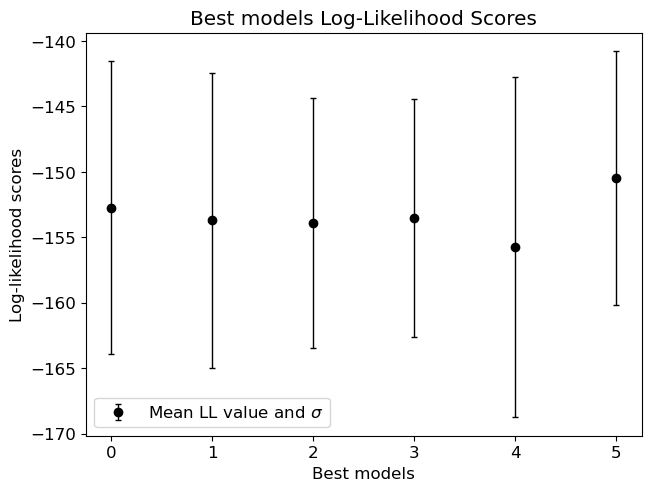

In [17]:
fig, ax = plt.subplots(layout='constrained')
ax.errorbar(range(len(llh_list)), np.mean(llh_list, axis=0), yerr=np.std(llh_list, axis=0), fmt='ok', lw=1, capsize=2, label='Mean LL value and $\\sigma$')
plt.title('Best models Log-Likelihood Scores')
plt.ylabel('Log-likelihood scores')
plt.xlabel('Best models')
plt.legend()
plt.show()

## Test generative power of the best model

Here we use model 5 to generate and show new data.

<Figure size 640x480 with 0 Axes>

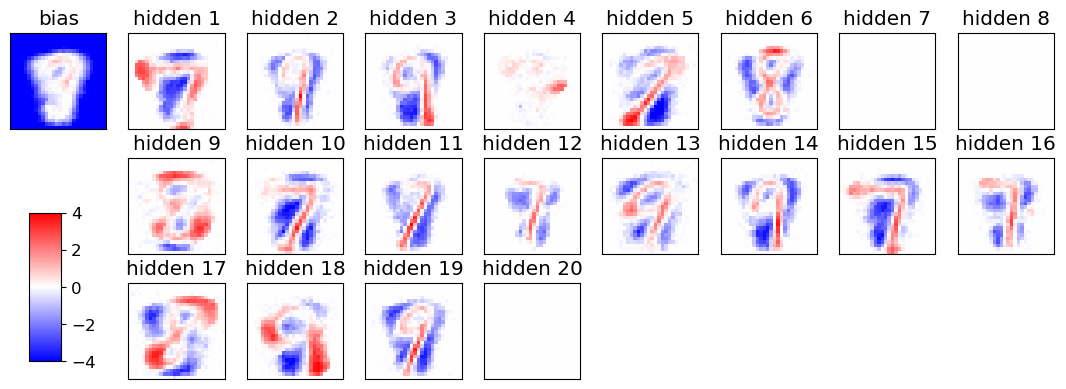

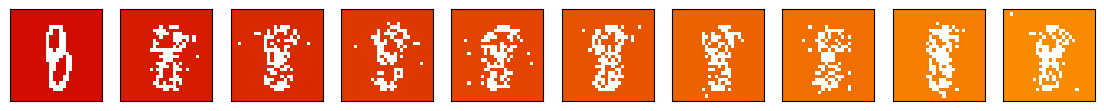

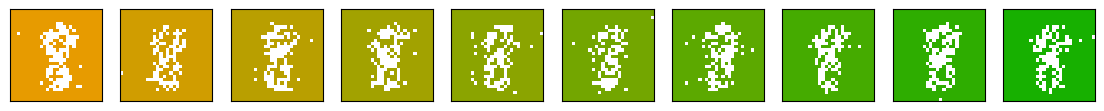

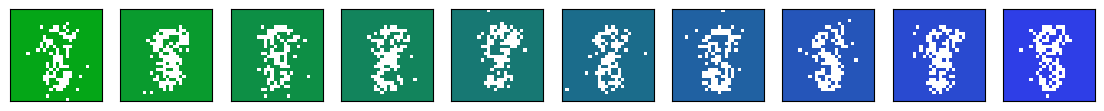

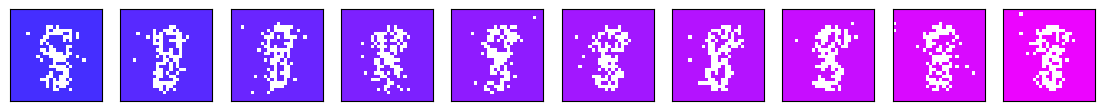

L: 20     amplification of weights: 1 lab 8


In [30]:
ee=-1 ##
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[(danum := np.random.randint(Nd))])
labf=label[danum]
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf
    zf = CD_step(xf,1*wE[ee],1*bE[ee], a_func=active, POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T, AF*aE[ee], a_func=active)
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF, 'lab', labf)

In [108]:
travj_x = np.mean(traj_x, axis=0)
bintravj_x = np.where(travj_x > .5, 1, 0)

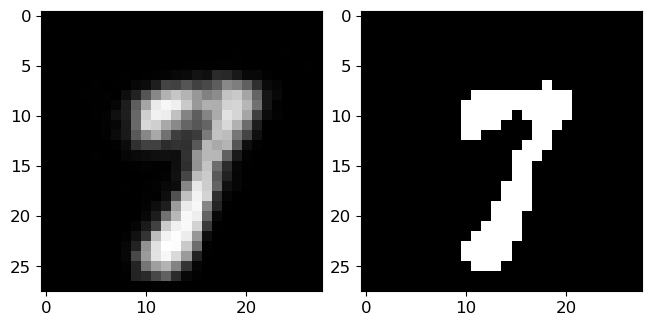

In [109]:
fig, ax = plt.subplots(1, 2, layout='constrained')
ax[0].imshow(travj_x.reshape(28,28), cmap='gray')
ax[1].imshow(bintravj_x.reshape(28,28), cmap='gray')
plt.show()


In [25]:
import os
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import re

folder_path = "img/"
# regex
pattern = re.compile(r"LLH_epoch150_L(\d)_CD(\d+)_lr0.05.png")

files = [
    (f, int(match.group(1)), int(match.group(2)), os.path.join(folder_path, f))
    for f in os.listdir(folder_path)
    if (match := pattern.match(f)) 
]

# Sort by L first, then CD
files.sort(key=lambda x: (x[1], x[2]))
# Extract only filenames
sorted_filenames = [f[0] for f in files]

row,cols = 5,6
fig,axes = plt.subplots(row,cols, figsize=(15,10), layout='constrained', dpi=1000)
axes = axes.flatten()
for i, img in enumerate(sorted_filenames[:row*cols]):
    image = Image.open('img/' +img)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()